# Project: Product Lifecycle & Customer Insights
This project analyzes customer orders, sales performance, and product trends using a sales & customer insight dataset. Data is stored in a MySQL database and analyzed with Python.
#### Business Objectives
-Understand customer purchase behavior across time, products, and regions

-Identify high-value customer segments to improve targeting

-Analyze churn patterns to reduce customer loss

-Optimize product and regional strategies to boost revenue




# Importing essential libraries 

In [2]:
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sb
import mysql.connector
import os
import numpy as np

# Configuration

In [11]:
# Define the MySQL connection parameters
mysql_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'IamArijit123@',
    'database': 'Sales_and_customerinsight'
}

# Define the CSV file path and the MySQL table name
csv_file = 'sales_and_customer_insights.csv'  
table_name = 'sales_insights_table'  


# Folder containing the CSV file
folder_path = r'C:\Jupyter Notebook\data'

# Helper Function

def get_sql_type(dtype):
    """
    Helper function to map pandas data types to MySQL data types.
    
    Args:
        dtype (pandas_dtype): The data type of a pandas column.
    
    Returns:
        str: Corresponding MySQL data type.
    """
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

# Establish the connection to the MySQL database using the provided credentials

conn = mysql.connector.connect(**mysql_config)
cursor = conn.cursor()

# CSV Data Processing and Table Insertion
# CSV Data Processing and Table Insertion
# Generate the file path for the CSV file
file_path = os.path.join(folder_path, csv_file)

# Read the CSV file into a pandas DataFrame
print(f"Processing {csv_file}...")
df = pd.read_csv(file_path)

# Handle NaN values by replacing them with None to map them to SQL NULL
df = df.where(pd.notnull(df), None)

# Debugging: Output NaN values count
print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

# Clean column names to be SQL-friendly (replace spaces, dashes, dots with underscores)
df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

# Create SQL Table

# Generate the CREATE TABLE statement with column data types
columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'

# Execute the table creation query
cursor.execute(create_table_query)

# Insert Data into MySQL Table

for _, row in df.iterrows():
    # Convert each row to a tuple and handle NaN values
    values = tuple(None if pd.isna(x) else x for x in row)
    
    # Generate the SQL INSERT query
    sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
    
    # Execute the SQL INSERT query with the row data
    cursor.execute(sql, values)

# Commit the transaction for the CSV file
conn.commit()

# Close Database Connection
# Close the MySQL connection after all data is processed
conn.close()

print("Data import completed successfully!")

Processing sales_and_customer_insights.csv...
NaN values before replacement:
Customer_ID                 0
Product_ID                  0
Transaction_ID              0
Purchase_Frequency          0
Average_Order_Value         0
Most_Frequent_Category      0
Time_Between_Purchases      0
Region                      0
Churn_Probability           0
Lifetime_Value              0
Launch_Date                 0
Peak_Sales_Date             0
Season                      0
Preferred_Purchase_Times    0
Retention_Strategy          0
dtype: int64

Data import completed successfully!


# Data Cleaning

In this section, we clean the dataset to ensure quality and consistency before analysis:
- Handle missing values
- Convert data types
- Remove duplicates
- Standardize text
- Detect outliers (optional)


In [12]:
# Shape and structure
print(df.shape)
print(df.info())
print(df.describe(include='all'))


(10000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               10000 non-null  object 
 1   Product_ID                10000 non-null  object 
 2   Transaction_ID            10000 non-null  object 
 3   Purchase_Frequency        10000 non-null  int64  
 4   Average_Order_Value       10000 non-null  float64
 5   Most_Frequent_Category    10000 non-null  object 
 6   Time_Between_Purchases    10000 non-null  int64  
 7   Region                    10000 non-null  object 
 8   Churn_Probability         10000 non-null  float64
 9   Lifetime_Value            10000 non-null  float64
 10  Launch_Date               10000 non-null  object 
 11  Peak_Sales_Date           10000 non-null  object 
 12  Season                    10000 non-null  object 
 13  Preferred_Purchase_Times  10000 non-null  object 


In [13]:
# Check for missing values
print(df.isnull().sum())

Customer_ID                 0
Product_ID                  0
Transaction_ID              0
Purchase_Frequency          0
Average_Order_Value         0
Most_Frequent_Category      0
Time_Between_Purchases      0
Region                      0
Churn_Probability           0
Lifetime_Value              0
Launch_Date                 0
Peak_Sales_Date             0
Season                      0
Preferred_Purchase_Times    0
Retention_Strategy          0
dtype: int64


In [14]:
#  Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates if any
df.drop_duplicates(inplace=True)

#  Ensure proper data types
df['Launch_Date'] = pd.to_datetime(df['Launch_Date'], errors='coerce')
df['Peak_Sales_Date'] = pd.to_datetime(df['Peak_Sales_Date'], errors='coerce')
df['Churn_Probability'] = df['Churn_Probability'].astype(float)
df['Purchase_Frequency'] = df['Purchase_Frequency'].astype(int, errors='ignore')
df['Average_Order_Value'] = df['Average_Order_Value'].astype(float, errors='ignore')
df['Time_Between_Purchases'] = df['Time_Between_Purchases'].astype(float, errors='ignore')
df['Lifetime_Value'] = df['Lifetime_Value'].astype(float, errors='ignore')


Number of duplicate rows: 0


In [17]:
# Outlier detection using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]


# Define columns outlier detection 
numeric_columns = ['Purchase_Frequency', 'Average_Order_Value', 'Time_Between_Purchases', 'Lifetime_Value']

# Loop over numeric columns to detect outliers
for column in numeric_columns:
    outliers = detect_outliers_iqr(df, column)
    print(f"Outliers in {column}: {len(outliers)}")

Outliers in Purchase_Frequency: 0
Outliers in Average_Order_Value: 0
Outliers in Time_Between_Purchases: 0
Outliers in Lifetime_Value: 0


# Exploratory Data Analysis (EDA)

In this phase, we aim to explore the dataset to uncover patterns, spot anomalies, test hypotheses, and check assumptions using summary statistics and graphical representations. The goal is to derive insights that can inform business decisions and further analysis.


In [3]:
# creating the Mysql cursor
db=mysql.connector.connect(host="localhost",username ="root",password ="IamArijit123@",database = "sales_and_customerinsight")
cur =db.cursor()

In [46]:
query="""select* from sales_insights_table"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data)
'''df.info()
df.head(20)'''
#df.describe()
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

## What is the distribution of Churn_Probability among all customers?

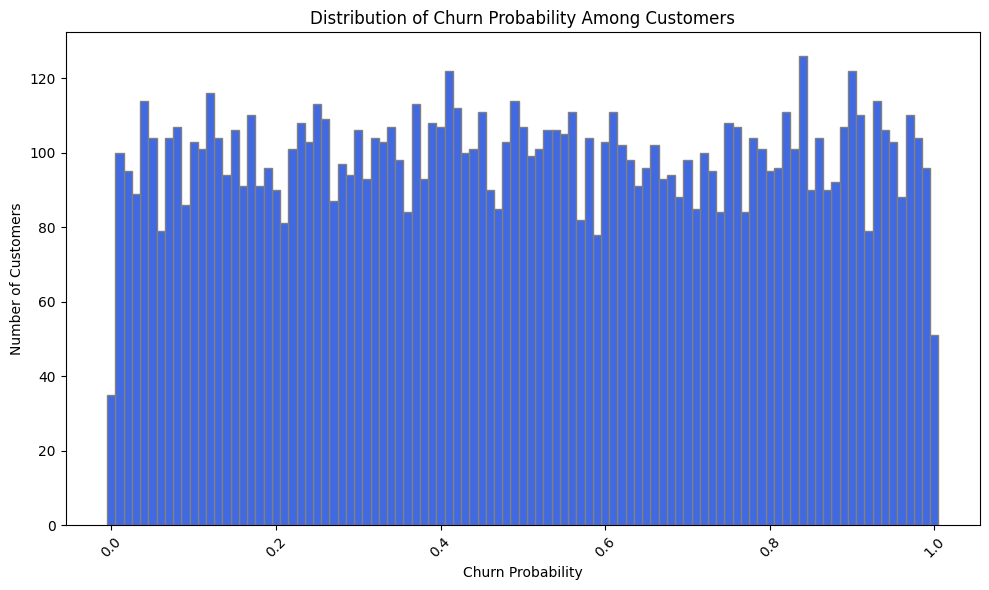

In [17]:
query="""select Churn_probability,count(*) from sales_insights_table group by Churn_probability """
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=['Churn_probability','customer_count'])
mpl.figure(figsize=(10,6))
mpl.bar(df['Churn_probability'],df['customer_count'],width=0.01,color='royalblue',edgecolor='grey')
mpl.xlabel('Churn Probability')
mpl.ylabel('Number of Customers')
mpl.title('Distribution of Churn Probability Among Customers')
mpl.xticks(rotation=45)
mpl.tight_layout()
mpl.show()

#### Key Findings
- Churn probability is evenly distributed across customers.
- Most customers fall in the medium-risk range (churn probability between 0.3 and 0.7).
- Fewer customers are at extreme low (0.0–0.1) or high (0.9–1.0) churn risk.

#### Recommendations
- Focus retention efforts on medium- and high-risk customers.

- Use targeted strategies for different churn segments (e.g., discounts for high-     risk, loyalty rewards for low-risk).

- Run A/B tests to find which retention strategy works best by risk group.

# Which Retention_Strategy is most commonly applied?

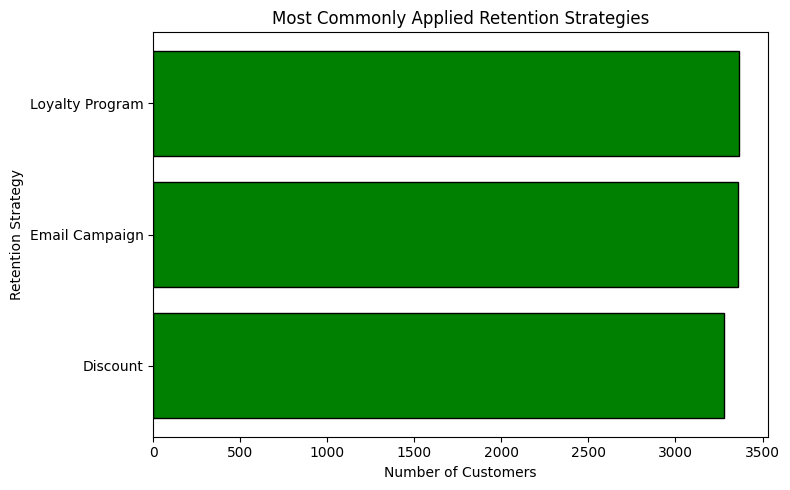

In [6]:
query="""SELECT Retention_Strategy, COUNT(*) FROM sales_insights_table GROUP BY Retention_Strategy ORDER BY COUNT(*) DESC """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Retention_Strategy', 'customer_count'])
df_sorted = df.sort_values(by='customer_count', ascending=True)
mpl.figure(figsize=(8,5))
mpl.barh(df_sorted['Retention_Strategy'],df_sorted['customer_count'],color ='green',edgecolor='black')
mpl.xlabel('Number of Customers')
mpl.ylabel('Retention Strategy')
mpl.title('Most Commonly Applied Retention Strategies')
mpl.tight_layout()
mpl.show()

#### Key Findings
- Loyalty Program is the most frequently applied retention strategy.

- Email Campaign is used nearly as often as the Loyalty Program.

- Discounts are slightly less used but still widely applied.

#### Recommendations:
- Evaluate the effectiveness of each strategy on reducing churn (not just usage).

- Consider expanding Email Campaigns if cost-effective and showing good ROI.

- Use data-driven segmentation to assign the most suitable strategy to each customer group.

# How does Average_Order_Value vary by Region?

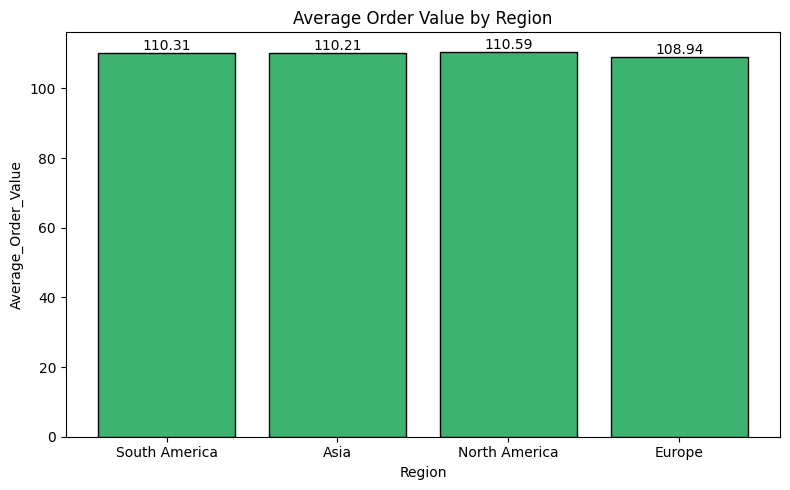

In [12]:
query="""SELECT Region, AVG(Average_Order_Value) 
FROM sales_insights_table 
GROUP BY Region;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Average_Order_Value', 'Region'])

fig, ax = mpl.subplots(figsize=(8, 5))
bars = ax.bar(df['Average_Order_Value'],df['Region'] , color='mediumseagreen', edgecolor='black')

# Add value labels to each bar
ax.bar_label(bars, fmt='%.2f')  # Display with two decimal places

ax.set_xlabel('Region')
ax.set_ylabel('Average_Order_Value')
ax.set_title('Average Order Value by Region')
mpl.tight_layout()
mpl.show()

#### Key Findings:
- South America has the highest average order value (≈ 110.31).

- Europe has the lowest (≈ 108.94), though the difference across regions is minimal.

#### Recommendations
- Continue strengthening South America and North America markets where spending is higher.

- Explore strategies (e.g., upselling, bundling) to boost average order value in Europe.

# Which products have the highest Purchase_Frequency?

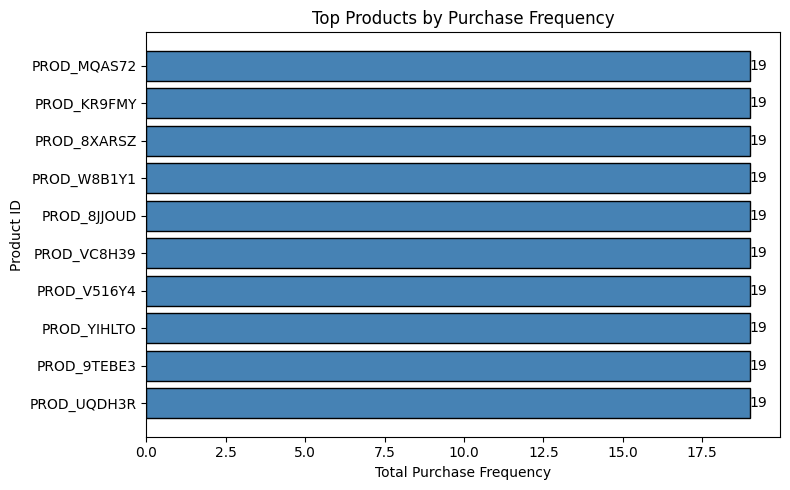

In [15]:
query="""SELECT Product_ID, SUM(Purchase_Frequency) 
FROM sales_insights_table 
GROUP BY Product_ID 
ORDER BY SUM(Purchase_Frequency) DESC;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Product_ID', 'Total_Purchase_Frequency'])
top_n = 10
df_top = df.head(top_n).sort_values('Total_Purchase_Frequency', ascending=True)
fig, ax = mpl.subplots(figsize=(8, 5))
bars = ax.barh(df_top['Product_ID'], df_top['Total_Purchase_Frequency'], color='steelblue', edgecolor='black')

# Add value labels to each bar
ax.bar_label(bars, fmt='%d')  # '%d' for integer values

ax.set_xlabel('Total Purchase Frequency')
ax.set_ylabel('Product ID')
ax.set_title('Top Products by Purchase Frequency')
mpl.tight_layout()
mpl.show()

#### Key Findings
- All top 10 products share the same purchase frequency (19 times).

- No single product significantly outperformed the others in frequency.

#### Recommendations
- These top-performing products can be used in promotional bundles or highlighted in marketing.

- Further analyze customer segments buying these to tailor future promotions.

# What are the Most_Frequent_Category products?

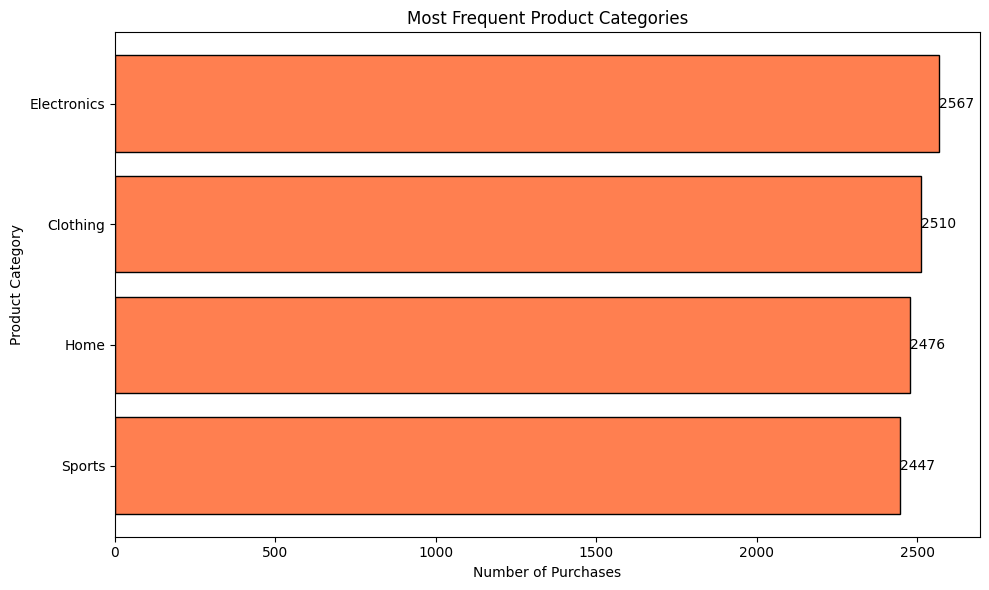

In [8]:
query="""SELECT Most_Frequent_Category, COUNT(*) 
FROM sales_insights_table 
GROUP BY Most_Frequent_Category 
ORDER BY COUNT(*) DESC;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Most_Frequent_Category', 'Category_Count'])
df_sorted = df.sort_values('Category_Count', ascending=True)
fig, ax = mpl.subplots(figsize=(10, 6))
bars = ax.barh(df_sorted['Most_Frequent_Category'], df_sorted['Category_Count'], color='coral', edgecolor='black')
ax.bar_label(bars, fmt='%d')
ax.set_xlabel('Number of Purchases')
ax.set_ylabel('Product Category')
ax.set_title('Most Frequent Product Categories')
mpl.tight_layout()
mpl.show()

#### Key Findings:
- Electronics is the most purchased category (2,567 purchases).

- Clothing, Home, and Sports follow closely, all with high purchase counts.

#### Recommendations:
Prioritize inventory and promotions in Electronics and Clothing.

Consider cross-selling products between top categories (e.g., Sports & Electronics).

#  How do sales (number of transactions or revenue) vary by Season?

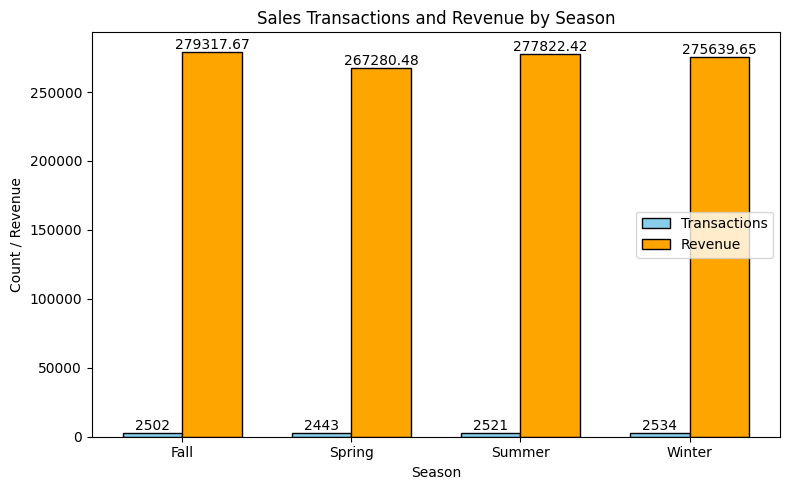

In [9]:
query="""SELECT 
    Season, 
    COUNT(*) AS Num_Transactions, 
    SUM(Average_Order_Value) AS Total_Revenue 
FROM 
    sales_insights_table 
GROUP BY 
    Season;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Season', 'Num_Transactions', 'Total_Revenue'])
df_sorted = df.sort_values('Season')  

x = np.arange(len(df_sorted['Season']))  #
width = 0.35

fig, ax = mpl.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, df_sorted['Num_Transactions'], width, label='Transactions', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, df_sorted['Total_Revenue'], width, label='Revenue', color='orange', edgecolor='black')

ax.bar_label(bars1, fmt='%d')
ax.bar_label(bars2, fmt='%.2f')

ax.set_xlabel('Season')
ax.set_ylabel('Count / Revenue')
ax.set_title('Sales Transactions and Revenue by Season')
ax.set_xticks(x)
ax.set_xticklabels(df_sorted['Season'])
ax.legend()
mpl.tight_layout()
mpl.show()

#### Key Findings:
- Fall generated the highest revenue (~279K), despite not having the most transactions.

- Winter had the highest number of transactions (2,534), with revenue close to Fall.

- Spring had the lowest revenue and transactions.

#### Recommendations:
- Boost marketing efforts in Spring to improve sales.

- Prepare inventory and campaigns ahead of Fall and Winter for maximum return.



# What are the most popular Preferred_Purchase_Times?

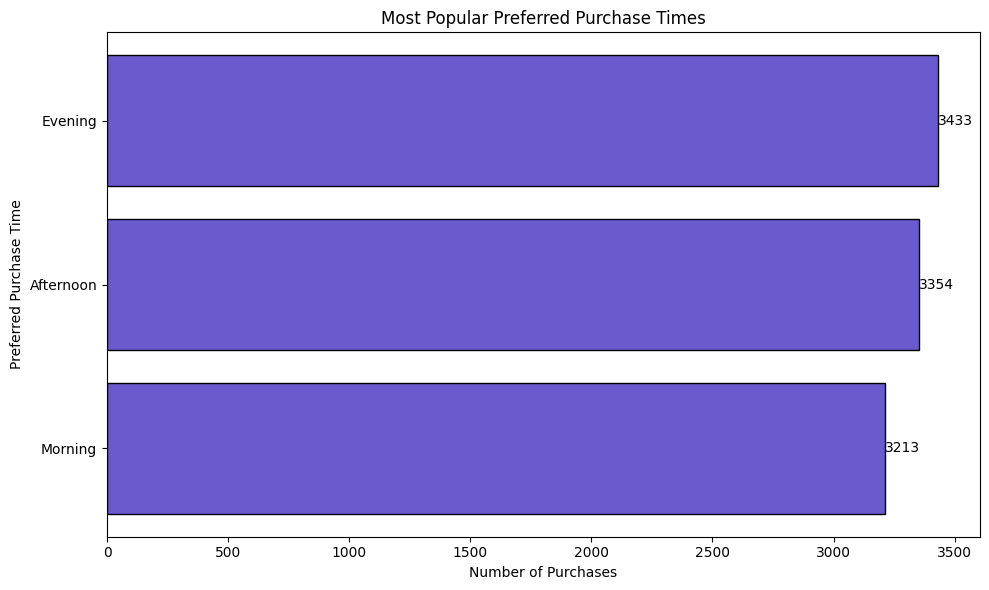

In [10]:
query="""SELECT Preferred_Purchase_Times, COUNT(*) 
FROM sales_insights_table 
GROUP BY Preferred_Purchase_Times 
ORDER BY COUNT(*) DESC;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Preferred_Purchase_Times', 'Purchase_Count'])
df_sorted = df.sort_values('Purchase_Count', ascending=True)

fig, ax = mpl.subplots(figsize=(10, 6))
bars = ax.barh(df_sorted['Preferred_Purchase_Times'], df_sorted['Purchase_Count'], color='slateblue', edgecolor='black')
ax.bar_label(bars, fmt='%d')
ax.set_xlabel('Number of Purchases')
ax.set_ylabel('Preferred Purchase Time')
ax.set_title('Most Popular Preferred Purchase Times')
mpl.tight_layout()
mpl.show()

#### Most Popular Purchase Times:
- Evening – 3,433 purchases

- Afternoon – 3,354 purchases

- Morning – 3,213 purchases

#### Insights & Actionable Strategies:
- Evening is the peak purchasing time — optimal for launching new products, email campaigns, and limited-time offers.

- Afternoon and morning still show strong engagement — consider spreading promotional efforts across these time blocks for full-day impact.

# Which Region has the highest total sales (sum of Average_Order_Value)?

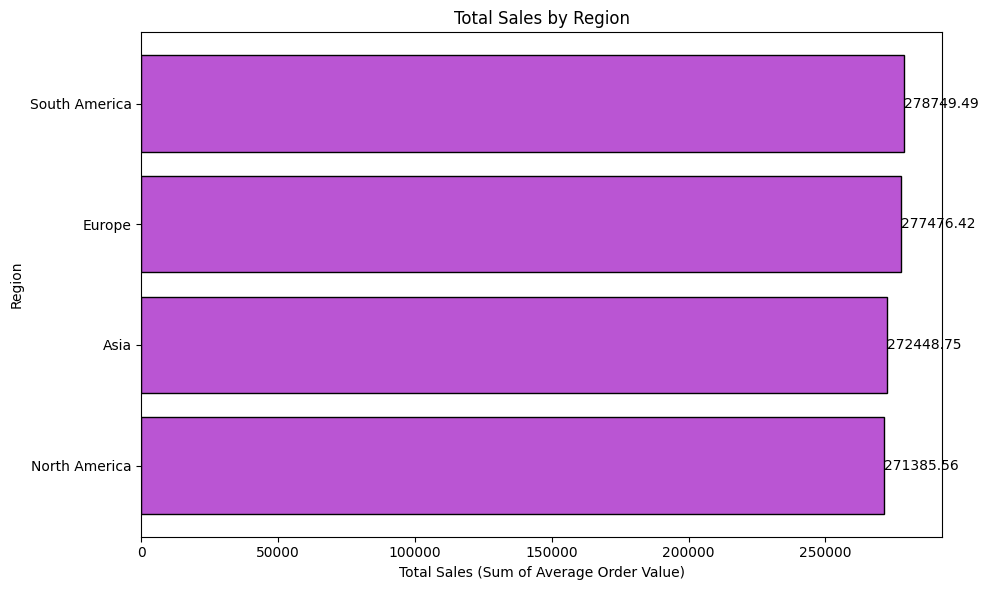

In [11]:
query="""SELECT Region, SUM(Average_Order_Value) AS Total_Sales
FROM sales_insights_table
GROUP BY Region
ORDER BY Total_Sales DESC;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Region', 'Total_Sales'])
df_sorted = df.sort_values('Total_Sales', ascending=True)

fig, ax = mpl.subplots(figsize=(10, 6))
bars = ax.barh(df_sorted['Region'], df_sorted['Total_Sales'], color='mediumorchid', edgecolor='black')
ax.bar_label(bars, fmt='%.2f')
ax.set_xlabel('Total Sales (Sum of Average Order Value)')
ax.set_ylabel('Region')
ax.set_title('Total Sales by Region')
mpl.tight_layout()
mpl.show()

 #### Total Sales by Region (Sum of Average Order Value):
- South America – 278,749.49

- Europe – 277,476.42

- Asia – 272,448.75

- North America – 271,385.56

#### Insights & Strategic Takeaways:
- South America is the top-performing region, with the highest total sales value.

- Europe and Asia follow closely, indicating well-distributed revenue across global markets.

- Consider scaling operations, localized marketing, or introducing regional promotions in South America to capitalize on strong performance.

# Which Retention_Strategy is most effective at reducing Churn_Probability?

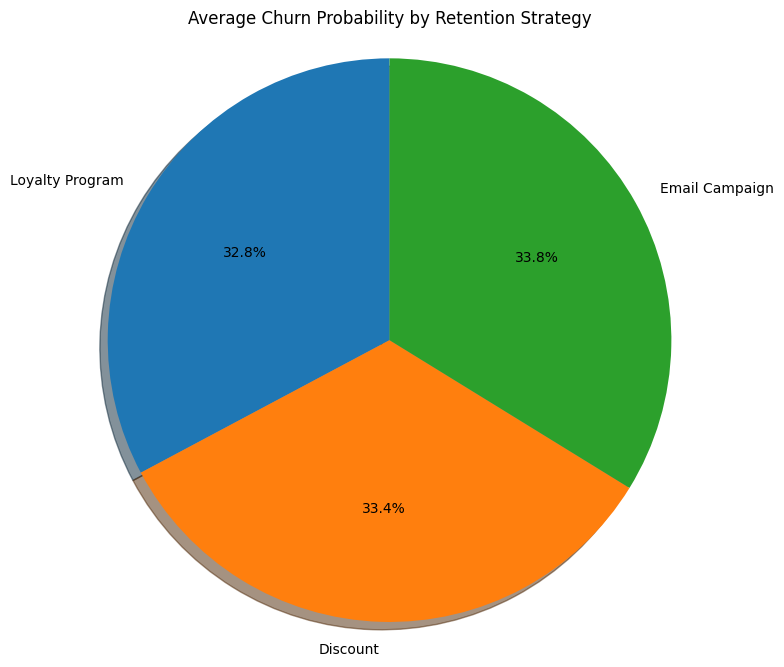

In [14]:
query="""SELECT Retention_Strategy, AVG(Churn_Probability) AS Avg_Churn_Probability
FROM sales_insights_table
GROUP BY Retention_Strategy
ORDER BY Avg_Churn_Probability ASC;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Retention_Strategy', 'Avg_Churn_Probability'])
sizes = df['Avg_Churn_Probability']
labels = df['Retention_Strategy']

fig, ax = mpl.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True)
ax.axis('equal')  # Equal aspect ratio ensures pie is circular
ax.set_title('Average Churn Probability by Retention Strategy')

mpl.show()

#### Average Churn Probability by Retention Strategy:
- Email Campaign – 33.8%

- Discount – 33.4%

- Loyalty Program – 32.8%

#### Conclusion:
The Email Campaign strategy is associated with the highest average churn probability (33.8%) among the three strategies.

 #### Recommendation:
- To reduce churn:

- Reassess the Email Campaign content, targeting, and frequency.

- Consider blending strategies, like combining emails with personalized discounts or loyalty incentives.

- A/B test new campaign formats to improve effectiveness.

# Is there a correlation between Time_Between_Purchases and Churn_Probability?


Correlation coefficient: 0.01041003642762427


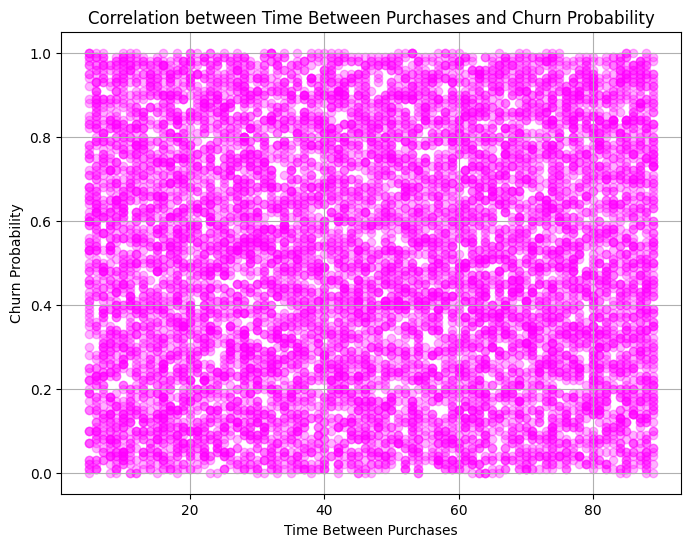

In [30]:
query="""SELECT Time_Between_Purchases, Churn_Probability
FROM sales_insights_table
WHERE Time_Between_Purchases IS NOT NULL AND Churn_Probability IS NOT NULL;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Time_Between_Purchases', 'Churn_Probability'])

# Calculate the correlation coefficient 
correlation = df['Time_Between_Purchases'].corr(df['Churn_Probability'])
print("Correlation coefficient:", correlation)

mpl.figure(figsize=(8, 6))
mpl.scatter(df['Time_Between_Purchases'], df['Churn_Probability'],color='magenta', alpha=0.3)
mpl.xlabel('Time Between Purchases')
mpl.ylabel('Churn Probability')
mpl.title('Correlation between Time Between Purchases and Churn Probability')
mpl.grid(True)
mpl.show()

#### Interpretation of the Scatter Plot:
- The plot titled "Correlation between Time Between Purchases and Churn Probability" uses hex bins to show the density of customer data points based on:

- X-axis: Time Between Purchases

- Y-axis: Churn Probability

#### Key Observations:
- The distribution appears uniform and highly dispersed, with no visible trend line or concentration.

- There is no obvious upward or downward trend—data points span the entire range of churn probabilities for all intervals of time between purchases.

#### Conclusion (Statistical Insight):
- There is likely no strong correlation between Time Between Purchases and Churn Probability.

#### Supporting Reference:
According to Harvard Business Review, customer churn is often influenced more by overall experience and engagement than simple transaction intervals alone.

#### Recommendation:
- Rely on multivariate models that include customer satisfaction, order issues,   engagement history, and support interactions rather than just time-based metrics.

- Use segmentation to assess if specific customer groups behave differently based on purchase frequency.


# How does Churn probability change over time?

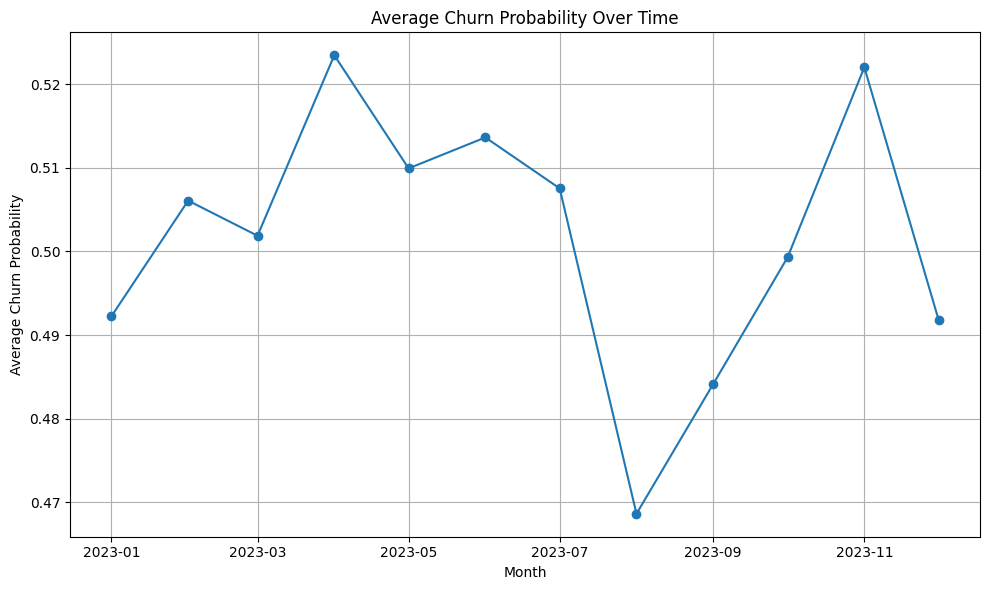

In [35]:
query="""SELECT 
    DATE_FORMAT(Peak_Sales_Date, '%Y-%m-01') AS Month,
    AVG(Churn_Probability) AS Avg_Churn_Probability
FROM sales_insights_table
GROUP BY Month
ORDER BY Month;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Month', 'Avg_Churn_Probability'])
df['Month'] = pd.to_datetime(df['Month'])
mpl.figure(figsize=(10, 6))
mpl.plot(df['Month'], df['Avg_Churn_Probability'], marker='o')
mpl.title('Average Churn Probability Over Time')
mpl.xlabel('Month')
mpl.ylabel('Average Churn Probability')
mpl.grid(True)
mpl.tight_layout()
mpl.show()

#### Key Findings:
- Churn probability fluctuates slightly throughout the year.

- Peaks observed in April and November (~0.52), suggesting increased churn risk in these months.

- Lowest churn in August (~0.47), indicating better customer stability mid-year.

#### Recommendations:
- Strengthen retention efforts in April and November (e.g., promotions, re-engagement).

- Analyze possible causes (e.g., seasonality, competitor activity) for churn spikes.

- Use mid-year (low churn) periods to build loyalty and prepare for high-risk months.

# What is the average Lifetime Value (CLV) by Most_Frequent_Category?

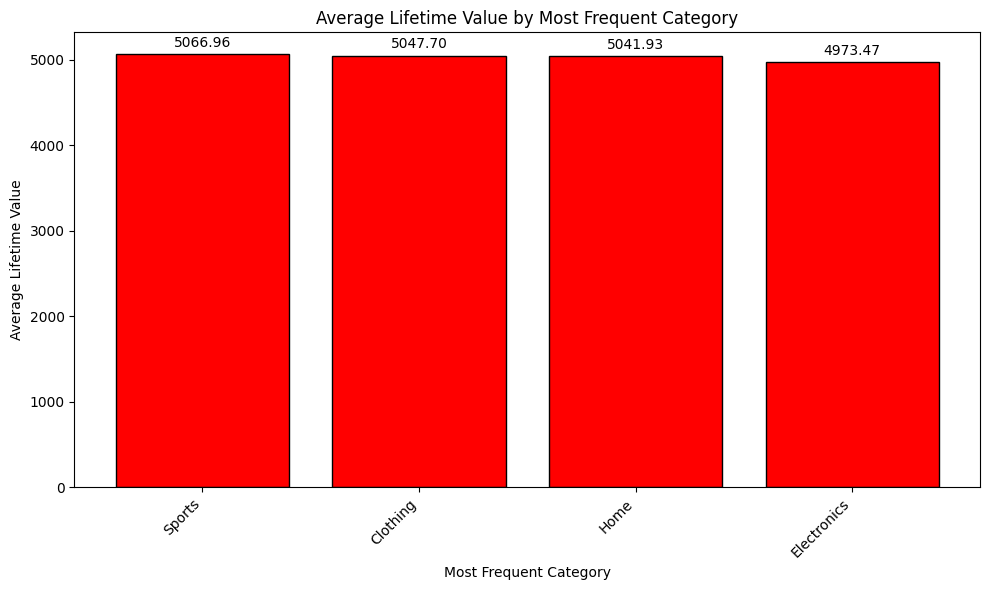

In [39]:
query="""SELECT Most_Frequent_Category, AVG(Lifetime_Value) AS Avg_Lifetime_Value
FROM sales_insights_table
GROUP BY Most_Frequent_Category
ORDER BY Avg_Lifetime_Value DESC;
"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=['Most_Frequent_Category','Avg_Lifetime_Value'])
df_sorted = df.sort_values('Avg_Lifetime_Value', ascending=False)

mpl.figure(figsize=(10, 6))
bars = mpl.bar(df_sorted['Most_Frequent_Category'], df_sorted['Avg_Lifetime_Value'], color='red', edgecolor='black')

mpl.bar_label(bars, fmt='%.2f', padding=3)
mpl.xlabel('Most Frequent Category')
mpl.ylabel('Average Lifetime Value')
mpl.title('Average Lifetime Value by Most Frequent Category')
mpl.xticks(rotation=45, ha='right')
mpl.tight_layout()
mpl.show()



#### Key Findings:
- Sports category customers have the highest average lifetime value (CLV) at ~5067.

- Clothing and Home categories follow closely (~5048 and ~5042).

- Electronics has the lowest average CLV at ~4973 among the four.

#### Recommendations:
- Focus marketing on Sports and Clothing buyers—they bring the highest lifetime value.

- Explore why Electronics lags slightly (e.g., fewer repeat purchases, price sensitivity).

- Consider bundling or loyalty perks in Electronics to boost long-term value.

# How does Purchase_Frequency relate to Churn_Probability?

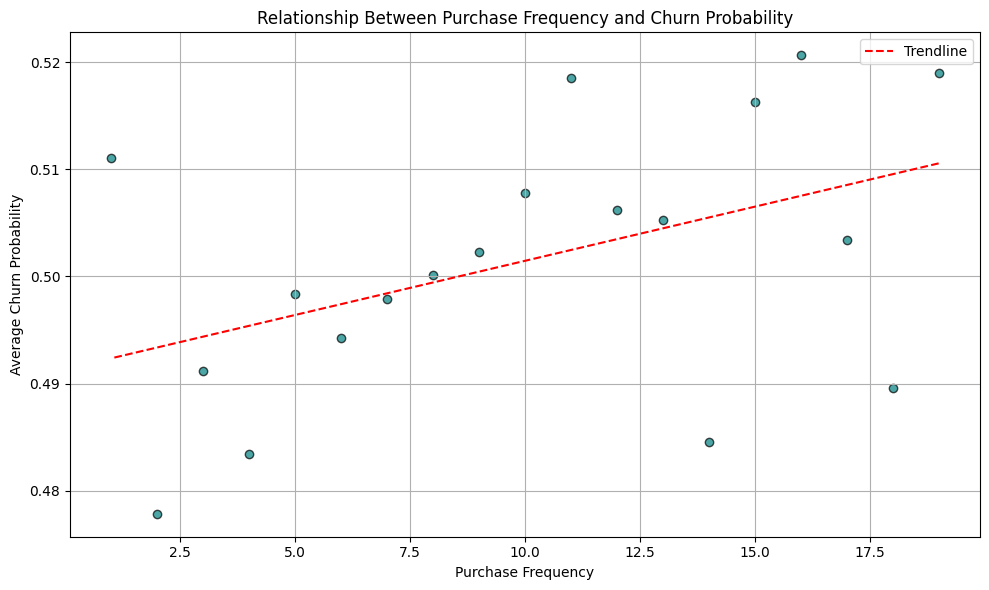

In [42]:
query="""SELECT Purchase_Frequency, AVG(Churn_Probability) AS Avg_Churn_Probability
FROM sales_insights_table
GROUP BY Purchase_Frequency
ORDER BY Purchase_Frequency DESC;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Purchase_Frequency', 'Avg_Churn_Probability'])

mpl.figure(figsize=(10, 6))
mpl.scatter(df['Purchase_Frequency'], df['Avg_Churn_Probability'], color='teal', edgecolor='black', alpha=0.7)
mpl.xlabel('Purchase Frequency')
mpl.ylabel('Average Churn Probability')
mpl.title('Relationship Between Purchase Frequency and Churn Probability')
mpl.grid(True)


# trendline (linear fit)

z = np.polyfit(df['Purchase_Frequency'], df['Avg_Churn_Probability'], 1)
p = np.poly1d(z)
mpl.plot(df['Purchase_Frequency'], p(df['Purchase_Frequency']), "r--", label='Trendline')
mpl.legend()

mpl.tight_layout()
mpl.show()

#### Key Findings:
- The trendline shows a slight positive correlation between purchase frequency and churn probability.

- This is unexpected — typically, more frequent buyers are less likely to churn.

- The relationship is weak and scattered, suggesting other factors may influence churn more strongly.


#### Recommendations:
- Investigate why frequent buyers might still churn (e.g., poor service, lack of new products).

- Use segmentation to understand if this pattern differs by category or region.

- Don’t rely solely on purchase frequency to predict churn — combine it with other metrics like Time_Between_Purchases or Customer Feedback.

# Which Region has the highest average Lifetime_Value?

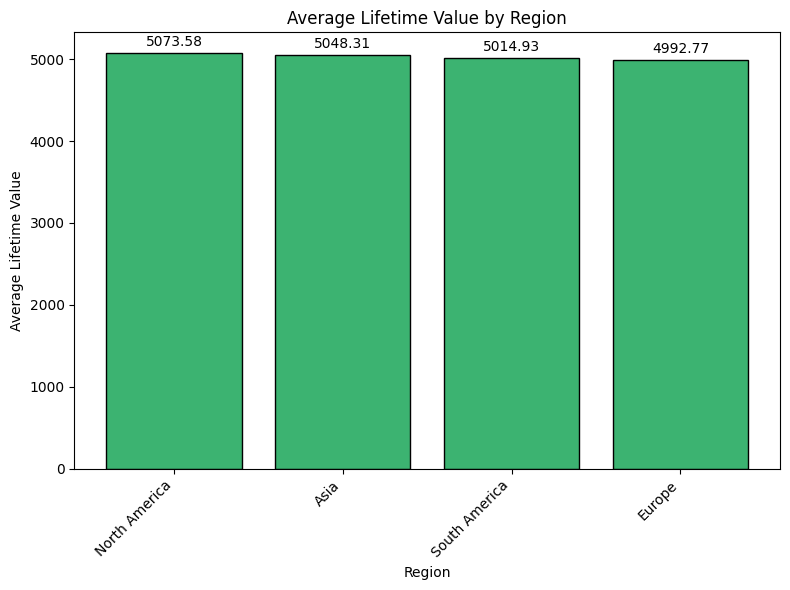

In [44]:
query="""SELECT Region, AVG(Lifetime_Value) AS Avg_Lifetime_Value
FROM sales_insights_table
GROUP BY Region
ORDER BY Avg_Lifetime_Value DESC;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Region', 'Avg_Lifetime_Value'])

df_sorted = df.sort_values('Avg_Lifetime_Value', ascending=False)

mpl.figure(figsize=(8, 6))
bars = mpl.bar(df_sorted['Region'], df_sorted['Avg_Lifetime_Value'], color='mediumseagreen', edgecolor='black')

mpl.bar_label(bars, fmt='%.2f', padding=3)

mpl.xlabel('Region')
mpl.ylabel('Average Lifetime Value')
mpl.title('Average Lifetime Value by Region')
mpl.xticks(rotation=45, ha='right')
mpl.tight_layout()
mpl.show()

#### kry findings
- North America highest average lifetime value -5073.58
- This is slightly higher than the other regions:

- Asia: 5048.31

- South America: 5014.93

- Europe: 4992.77

- The differences are relatively small, but North America leads overall.

 # What is the distribution of Preferred_Purchase_Times across different Seasons?

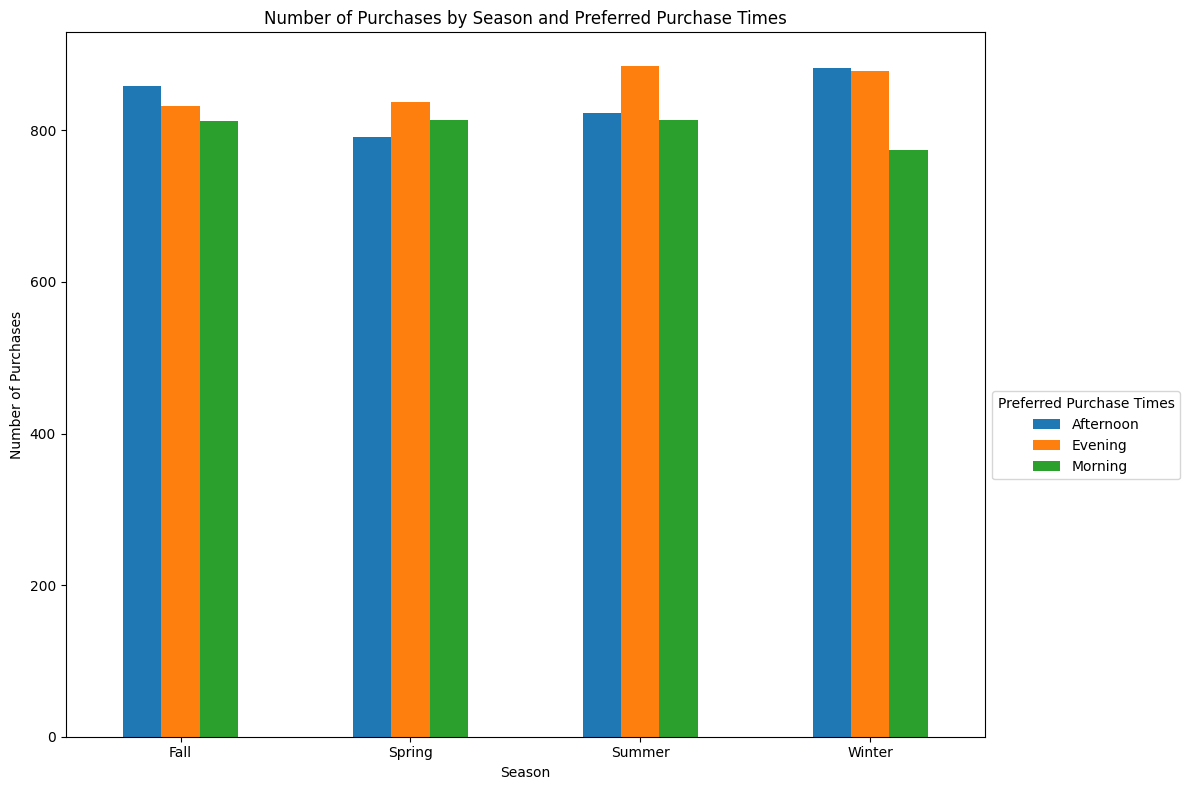

In [54]:
query="""SELECT Season, Preferred_Purchase_Times, COUNT(*) AS Num_Purchases
FROM sales_insights_table
GROUP BY Season, Preferred_Purchase_Times
ORDER BY Season, Num_Purchases DESC;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['Season', 'Preferred_Purchase_Times', 'Num_Purchases'])

# Pivot the DataFrame
pivot_df = df.pivot(index='Season', columns='Preferred_Purchase_Times', values='Num_Purchases')

pivot_df.plot(kind='bar', figsize=(12, 8))
mpl.title('Number of Purchases by Season and Preferred Purchase Times')
mpl.xlabel('Season')
mpl.ylabel('Number of Purchases')
mpl.xticks(rotation=0)
mpl.legend(loc='upper left', bbox_to_anchor=(1, 0.5),title='Preferred Purchase Times')
mpl.tight_layout()
mpl.show()

#### Description
The distribution of Preferred Purchase Times across different Seasons (based on the bar chart) can be summarized as follows:

#### Fall
- Afternoon: Highest purchases (~875+)

- Evening: Slightly lower than Afternoon
- Morning: Lowest among the three, but close

#### Spring
- Evening: Highest purchases

- Morning: Second highest

- Afternoon: Lowest in Spring (~790)

#### Summer
- Evening: Clearly the highest (~890+)

- Afternoon and Morning: Very close, both slightly above 800

#### Winter
- Afternoon and Evening: Nearly identical and highest (~890)

- Morning: Noticeably lower (~770+), making it the least preferred in Winter

#### Key Insights
- Evening is the most preferred purchase time overall, especially in Summer and Spring.

- Afternoon dominates in Fall and ties with Evening in Winter.

- Morning consistently has the lowest number of purchases across all seasons.


# Conclusion and Next Steps


####  Summary of Key Insights
- Evening is the most preferred purchase time, especially in Summer and Spring.

- Fall generated the highest revenue, while Winter had the most transactions.

- South America leads in both total sales and average order value.

- North America has the highest average customer lifetime value.

- Sports is the top category by average CLV; Electronics is the most purchased category.

- Churn Probability is evenly spread; most customers are in the medium-risk group (0.3–0.7).

- A slight positive correlation exists between purchase frequency and churn — suggests deeper factors at play.

- Email Campaigns show the highest churn risk, while Loyalty Programs are the most used strategy.



#### Recommended Actions
- Target medium- and high-risk customers with personalized retention strategies such as loyalty programs and discounts.

- Expand marketing and operations in South America due to strong revenue and average order value performance.

- Run promotions during evening hours, especially in Fall and Winter when engagement and revenue are highest.

- Promote high customer lifetime value categories like Sports, Clothing, and Home to increase long-term profitability.

- Reassess the effectiveness of Email Campaigns, and test alternative strategies for high-risk customer segments.
